 # Working with CMEMS, SWOT and NOAA data

### Introduction
This notebook aims to compare surface current data from three data sources: Drifter, Cmems, and Swot.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Data Product: Global Drifter Program Current of NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 136
  - https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - period :  02-04-2023 to 09-07-2023
    
- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 24 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047
  - link :  https://doi.org/10.48670/moi-00148
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download
  - Periode : period : 02-04-2023 to 09-07-2023

- SWOT Data:
  - Source: Altimetry measurements,  L3 SWOT (NASA/CNES), Temporal resolution: Every Time, Spatial resolution: 
  - Data Product: NRT SWOT KaRIn & nadir Global Ocean swath SSALTO/DUACS Sea Surface Height L3 product
  - link :  DOI associated : https://doi.org/10.24400/527896/a01-2023.017
  - download data : https://filesender.renater.fr/?s=download&token=02607a61-c1aa-4f00-8b4e-9c26454c9260
  - Periode : period :  02-04-2023 to 09-07-2023
  - DUACS is the operationnal multimission production system of altimeter data developed by CNES/CLS. It features multimission products based on all altimetry satellites from GEOSAT to Jason-3 for a total of 100 years of cumulated data.
 
### Tasks

#### Comparison
 - Interpolate the CMEMS and SWOT geostrophic currents onto the spatial and temporal grid of the drifters.
 - Compare the three current sources using the Pearson correlation test, the correlation coefficient, and RMSE.

## Import packages


In [1]:
import os
import glob
import scipy
import numpy
import numpy as np
import xarray as xr
import pandas as pd

from scipy.signal import hann, convolve

import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset

## SWOT and CMEMS

## Combine SWOT data

In [2]:
# Répertoire contenant les fichiers NetCDF
repertoire = 'C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/'

# Trouve tous les fichiers NetCDF dans le répertoire
fichiers_netcdf = glob.glob(os.path.join(repertoire, '*.nc'))

# Listes pour stocker les données extraites
swot_ssh = []
swot_ugosa = []
swot_vgosa = []
swot_ugos = []
swot_vgos = []
swot_lon = []
swot_lat = []
temps = []

# Parcours de chaque fichier NetCDF
for fichier in fichiers_netcdf:
    # Ouvre le fichier NetCDF avec xarray
    dataset = xr.open_dataset(fichier)
    
    # Extrait les données et les ajoute aux listes
    ugosa = dataset.ugosa.values
    vgosa = dataset.vgosa.values
    ugos = dataset.ugos.values
    vgos = dataset.vgos.values
    lon = dataset.longitude.values
    lat = dataset.latitude.values
    ssh = dataset.ssha_noiseless.values
    t = dataset.time.values  

    swot_ssh.append(ssh)
    swot_ugosa.append(ugosa)
    swot_vgosa.append(vgosa)
    swot_ugos.append(ugos)
    swot_vgos.append(vgos)
    swot_lon.append(lon)
    swot_lat.append(lat)
    temps.append(t)
    
    # Ferme le dataset
    dataset.close()

# mean
swot_ssh_mean =  np.nanmean(swot_ssh, axis=0)
swot_ugosa_mean =  np.nanmean(swot_ugosa, axis=0)
swot_vgosa_mean =  np.nanmean(swot_vgosa, axis=0)
swot_ugos_mean =   np.nanmean(swot_ugos, axis=0)
swot_vgos_mean =   np.nanmean(swot_vgos, axis=0)
swot_lon_mean =   np.nanmean(swot_lon, axis=0)
swot_lat_mean =   np.nanmean(swot_lat, axis=0)
temps_array = np.concatenate(temps, axis=0)  

# Afficher les résultats
print("swot_ssh_array shape:", swot_ssh_mean.shape)
print("swot_ugosa_array shape:", swot_ugosa_mean.shape)
print("swot_vgosa_array shape:", swot_vgosa_mean.shape)
print("swot_ugos_array shape:", swot_ugos_mean.shape)
print("swot_vgos_array shape:", swot_vgos_mean.shape)
print("swot_lon_array shape:", swot_lon_mean.shape)
print("swot_lat_array shape:", swot_lat_mean.shape)
print("temps_array shape:", temps_array.shape)

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2654295078.py:45: RuntimeWarning: Mean of empty slice
  swot_ssh_mean =  np.nanmean(swot_ssh, axis=0)
C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2654295078.py:46: RuntimeWarning: Mean of empty slice
  swot_ugosa_mean =  np.nanmean(swot_ugosa, axis=0)
C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2654295078.py:47: RuntimeWarning: Mean of empty slice
  swot_vgosa_mean =  np.nanmean(swot_vgosa, axis=0)
C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2654295078.py:48: RuntimeWarning: Mean of empty slice
  swot_ugos_mean =   np.nanmean(swot_ugos, axis=0)
C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2654295078.py:49: RuntimeWarning: Mean of empty slice
  swot_vgos_mean =   np.nanmean(swot_vgos, axis=0)


swot_ssh_array shape: (9860, 69)
swot_ugosa_array shape: (9860, 69)
swot_vgosa_array shape: (9860, 69)
swot_ugos_array shape: (9860, 69)
swot_vgos_array shape: (9860, 69)
swot_lon_array shape: (9860, 69)
swot_lat_array shape: (9860, 69)
temps_array shape: (936700,)


##  Sorting and Read CMEMS data

## Sorting

In [3]:
# Chemin vers le fichier NetCDF d'entrée
fichier_entree = 'C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ugos_vgos.nc'
# Chemin vers le fichier NetCDF de sortie
fichier_sortie = 'C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ugos_vgos_filter.nc'

# Charger le fichier NetCDF avec xarray
dataset = xr.open_dataset(fichier_entree)

# Indices des jours à supprimer
jours_a_supprimer = [48, 49, 50, 61]

# Conserver tous les indices sauf ceux à supprimer
indices_a_conserver = [i for i in range(dataset.sizes['time']) if i not in jours_a_supprimer]

# Créer un nouvel ensemble de données en excluant les jours spécifiés
dataset_modifie = dataset.isel(time=indices_a_conserver)

# Sauvegarder le nouvel ensemble de données dans un nouveau fichier NetCDF
dataset_modifie.to_netcdf(fichier_sortie)

# Fermer les datasets
dataset.close()
dataset_modifie.close()

print("Les jours spécifiés ont été supprimés et les données modifiées ont été sauvegardées dans", fichier_sortie)

Les jours spécifiés ont été supprimés et les données modifiées ont été sauvegardées dans C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ugos_vgos_filter.nc


## Sorting (ue_ve)

In [4]:
# Chemin vers le fichier NetCDF d'entrée
fichier_entree_ue_ve = 'C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ue_ve.nc'
# Chemin vers le fichier NetCDF de sortie
fichier_sortie_ue_ve = 'C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ue_ve_filter.nc'

# Charger le fichier NetCDF avec xarray
dataset = xr.open_dataset(fichier_entree_ue_ve)

# Indices des jours à supprimer
jours_a_supprimer = [48, 49, 50, 61]

# Conserver tous les indices sauf ceux à supprimer
indices_a_conserver = [i for i in range(dataset.sizes['time']) if i not in jours_a_supprimer]

# Créer un nouvel ensemble de données en excluant les jours spécifiés
dataset_modifie = dataset.isel(time=indices_a_conserver)

# Sauvegarder le nouvel ensemble de données dans un nouveau fichier NetCDF
dataset_modifie.to_netcdf(fichier_sortie_ue_ve)

# Fermer les datasets
dataset.close()
dataset_modifie.close()

print("Les jours spécifiés ont été supprimés et les données modifiées ont été sauvegardées dans", fichier_sortie)

Les jours spécifiés ont été supprimés et les données modifiées ont été sauvegardées dans C:/Users/PC-M2OA/Desktop/vue_ens_2019_2023/SWOT_2/ugos_vgos_filter.nc


##  Read Variable

In [5]:
# Charger le fichier NetCDF avec xarray
dataset = xr.open_dataset(fichier_sortie)

ugos_cmems = dataset.ugos.values
vgos_cmems = dataset.vgos.values
latitude_cmems = dataset.latitude.values
longitude_cmems = dataset.longitude.values
time_cmems = dataset.time.values

cmems_ugos_mean =  np.mean(ugos_cmems, axis=0)
cmems_vgos_mean =  np.mean(vgos_cmems, axis=0)

# Charger le fichier NetCDF avec xarray
datasets = xr.open_dataset(fichier_sortie_ue_ve)

ue_cmems = datasets.ue.values
ve_cmems = datasets.ve.values

latitude_cmem = datasets.latitude.values
longitude_cmem = datasets.longitude.values
 
cmems_ue_mean =  np.mean(ue_cmems, axis=0)
cmems_ve_mean =  np.mean(ve_cmems, axis=0)

## Ekman plus geostrophic

# cmems_ugos_mean =  cmems_ugos_means + cmems_ue_mean
# cmems_vgos_mean =  cmems_vgos_means + cmems_ve_mean

## SWOT and CMEMS

## ugeos SWOT Interpolate

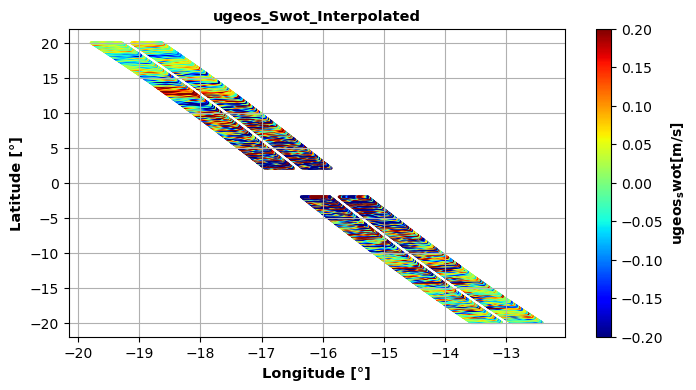

In [6]:
lat_s = swot_lat_mean
lon_s = swot_lon_mean
lon_s = np.where(lon_s > 180, lon_s - 360, lon_s)

# ugosa = np.nanmean(ugosa_swot, axis=0)
ugosa_s = swot_ugosa_mean

# Filtrer les données pour ne conserver que les longitudes entre -50 et 50
longitude_mask = (lon_s >= -50) & (lon_s <= 50)

# Appliquer le filtre aux données originales (avant d'aplatir)
lat_filtered = lat_s[longitude_mask]
lon_filtered = lon_s[longitude_mask]
# ugosa_filtered = ugosa_s[longitude_mask] + cmems_ue_mean[longitude_mask]
ugosa_filtered = ugosa_s[longitude_mask]

# Aplatir les tableaux pour faciliter le filtrage
lat_flat = lat_filtered.flatten()
lon_flat = lon_filtered.flatten()
ugosa_flat = ugosa_filtered.flatten()

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Interpoler les données
ugosa_swot_interp = griddata((lon_flat, lat_flat), ugosa_flat, (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
# plt.scatter(grid_x, grid_y, swot_new, vmin=-0.2, vmax=0.2 )
plt.scatter(grid_x,grid_y,c=ugosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

plt.colorbar(label=r'$\mathbf{ugeos_swot [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('ugeos_Swot_Interpolated', fontsize=10.5, fontweight='bold')
plt.show()

## ugeos CMEMS Interpolate

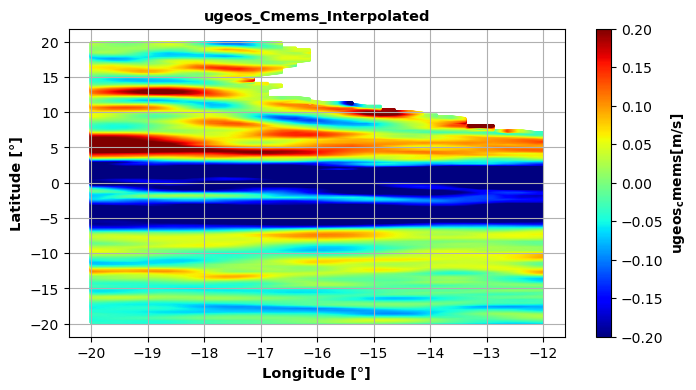

In [7]:
lat_c = latitude_cmems
lon_c = longitude_cmems

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Créer une grille 2D pour les coordonnées d'origine
lon_grid, lat_grid = np.meshgrid(lon_c, lat_c)

# Interpoler les données
ugosa_cmems_interp = griddata((lon_grid.flatten(), lat_grid.flatten()), cmems_ugos_mean.flatten(), (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
plt.scatter(grid_x, grid_y, c=ugosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label=r'$\mathbf{ugeos_cmems [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('ugeos_Cmems_Interpolated', fontsize=10.5, fontweight='bold')
plt.show()

## u-ekman CMEMS Interpolate

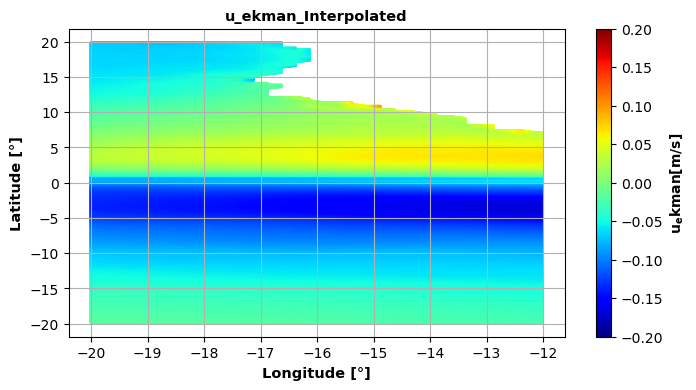

In [8]:
lat_c = latitude_cmem
lon_c = longitude_cmem

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Créer une grille 2D pour les coordonnées d'origine
lon_grid, lat_grid = np.meshgrid(lon_c, lat_c)

# Interpoler les données
u_ekman_interp = griddata((lon_grid.flatten(), lat_grid.flatten()), cmems_ue_mean.flatten(), (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
plt.scatter(grid_x, grid_y, c=u_ekman_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label=r'$\mathbf{u_ekman [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('u_ekman_Interpolated', fontsize=10.5, fontweight='bold')
plt.show()

## Correlation test

### Filtering out outlier values

In [9]:
# Créer un masque logique pour les valeurs valides
valid_indice_swot = (ugosa_swot_interp <= 1.1) & (ugosa_swot_interp >= -1.1)
valid_indice_cmems = (ugosa_cmems_interp <= 1.1) & (ugosa_cmems_interp >= -1.1)

# Appliquer le masque pour filtrer directement, en remplaçant les valeurs non valides par NaN
ugosa_swot_filte = np.where(valid_indice_swot, ugosa_swot_interp, np.nan)
ugosa_cmems_filte = np.where(valid_indice_cmems, ugosa_cmems_interp, np.nan)

### Moving average over different windows

In [10]:
# Créer une matrice 2400x480 remplie de NaN
ugosa_swot_filter = np.full((2400, 480), np.nan)

fenetre = 60
# fenetre[7 15 30 40 60 65] = coefficient_correlation[0.38  0.61 0.74 0.78 0.81 0.80]

# Boucle à travers chaque élément de la matrice
for i in range(2400):
    for j in range(480):
        # Ne faire l'opération que si l'élément actuel n'est pas NaN
        if not np.isnan(ugosa_swot_filte[i, j]):
            # Déterminer les indices de découpage, en tenant compte des limites
            i_min = max(0, i - fenetre)
            i_max = min(2400, i + fenetre)
            j_min = max(0, j - fenetre)
            j_max = min(480, j + fenetre)

            # Extraire la sous-matrice
            sub_matrix = ugosa_swot_filte[i_min:i_max, j_min:j_max]
            
            # Calculer la médiane en ignorant NaN
            median_value = np.nanmedian(sub_matrix)
            
            # Vérifier si la valeur calculée est différente de NaN avant d'affecter la valeur
            if not np.isnan(median_value):
                ugosa_swot_filter[i, j] = median_value

## Test 

Corrélation de Pearson: 0.8042258227393247
Valeur de p (p-value): 0.0


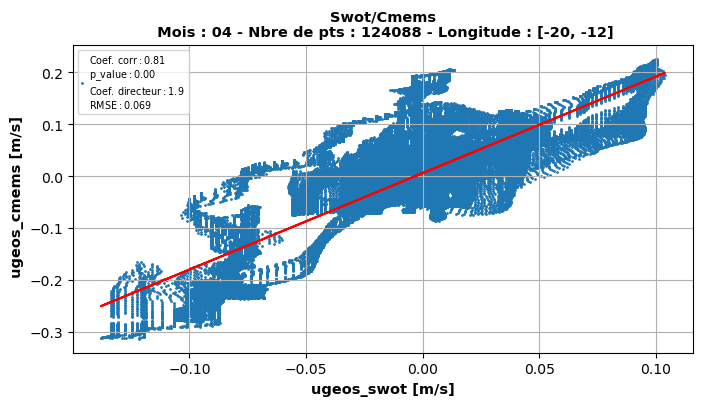

In [11]:
# Convert lists to NumPy arrays
ugosa_swot = ugosa_swot_filter.flatten()
ugosa_cmems = ugosa_cmems_filte.flatten()

# Supprimer les lignes où ugosa_swot et ugosa_cmems contiennent les NaN  
mask = ~np.isnan(ugosa_swot) & ~np.isnan(ugosa_cmems)
ugosa_swot_clean = ugosa_swot[mask]
ugosa_cmems_clean = ugosa_cmems[mask]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(ugosa_swot_clean, ugosa_cmems_clean)

# Calcul de la régression linéaire
coefficients = np.polyfit(ugosa_swot_clean, ugosa_cmems_clean, 1)
p = np.poly1d(coefficients) # p = 1.9

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((ugosa_swot_clean - ugosa_cmems_clean)**2)) # r = 0.069

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

slope, intercept, _, _, _ = linregress( ugosa_swot_clean,ugosa_cmems_clean)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(ugosa_swot_clean, ugosa_cmems_clean, s=1)

plt.plot(ugosa_swot_clean, slope*ugosa_swot_clean + intercept, color='red', label='Linear Regression')

plt.xlabel('ugeos_swot [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel(' ugeos_cmems [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.81$' + '\n'
    r'$\text{p_value} : 0.00$' + '\n'
    r'$\text{Coef. directeur} : 1.9$' + '\n'
    r'$\text{RMSE} : 0.069$'
)
# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Swot/Cmems\n Mois : 04 - Nbre de pts : 124088 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
 
plt.grid(True)
plt.show()

## Time series

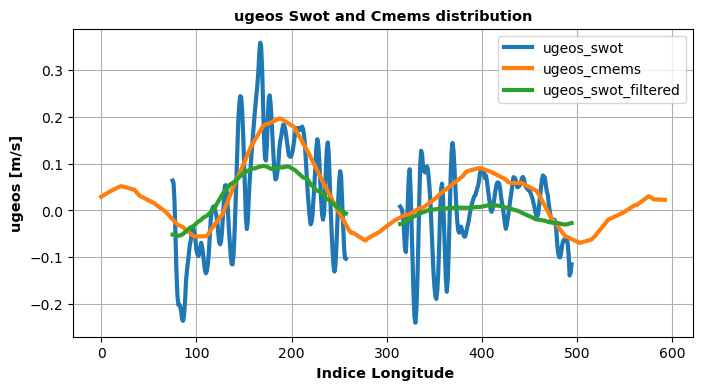

In [12]:
j=100
plt.figure(figsize=(8, 4))
plt.plot(ugosa_swot_filte[1800:2400,j], label ='ugeos_swot', linewidth=3)
plt.plot(ugosa_cmems_filte[1800:2400,j], label ='ugeos_cmems', linewidth=3)
plt.plot(ugosa_swot_filter[1800:2400,j], label ='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel(' Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'ugeos Swot and Cmems distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show()

## vgeos SWOT Interpolate

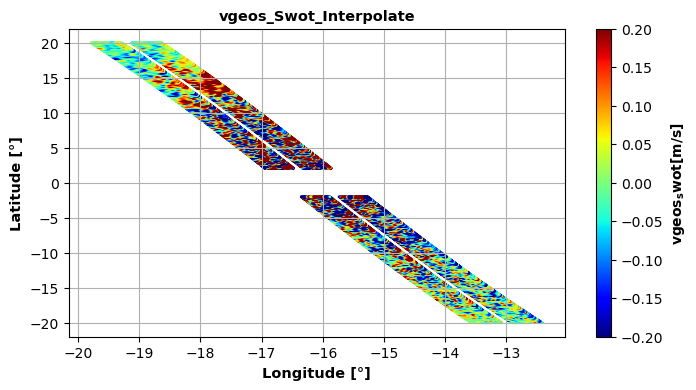

In [13]:
lat_s = swot_lat_mean
lon_s = swot_lon_mean
lon_s = np.where(lon_s > 180, lon_s - 360, lon_s)

# ugosa = np.nanmean(ugosa_swot, axis=0)
vgosa_s = swot_vgosa_mean

# Filtrer les données pour ne conserver que les longitudes entre -50 et 50
longitude_mask = (lon_s >= -50) & (lon_s <= 50)

# Appliquer le filtre aux données originales (avant d'aplatir)
lat_filtered = lat_s[longitude_mask]
lon_filtered = lon_s[longitude_mask]
vgosa_filtered = vgosa_s[longitude_mask]

# Aplatir les tableaux pour faciliter le filtrage
lat_flat = lat_filtered.flatten()
lon_flat = lon_filtered.flatten()
vgosa_flat = vgosa_filtered.flatten()

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Interpoler les données
vgosa_swot_interp = griddata((lon_flat, lat_flat), vgosa_flat, (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
# plt.scatter(grid_x, grid_y, swot_new, vmin=-0.2, vmax=0.2 )
plt.scatter(grid_x,grid_y,c=vgosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

plt.colorbar(label=r'$\mathbf{vgeos_swot [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Swot_Interpolate', fontsize=10.5, fontweight='bold')
plt.show()

## vgeos CMEMS Interpolate

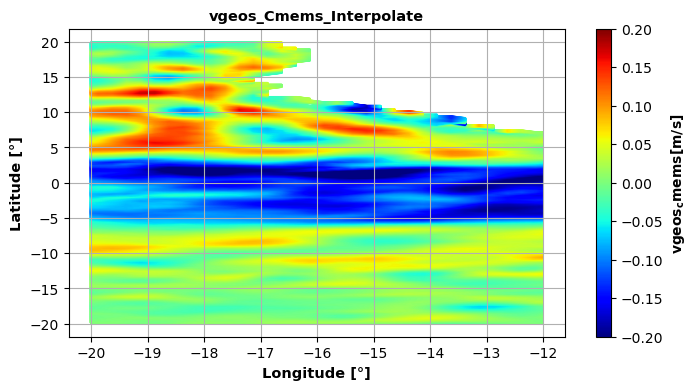

In [14]:
lat_c = latitude_cmems
lon_c = longitude_cmems

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Créer une grille 2D pour les coordonnées d'origine
lon_grid, lat_grid = np.meshgrid(lon_c, lat_c)

# Interpoler les données
vgosa_cmems_interp = griddata((lon_grid.flatten(), lat_grid.flatten()), cmems_vgos_mean.flatten(), (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
plt.scatter(grid_x, grid_y, c=vgosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label= r'$\mathbf{vgeos_cmems [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Cmems_Interpolate', fontsize=10.5, fontweight='bold')
plt.show()

## v-ekman CMEMS Interpolate

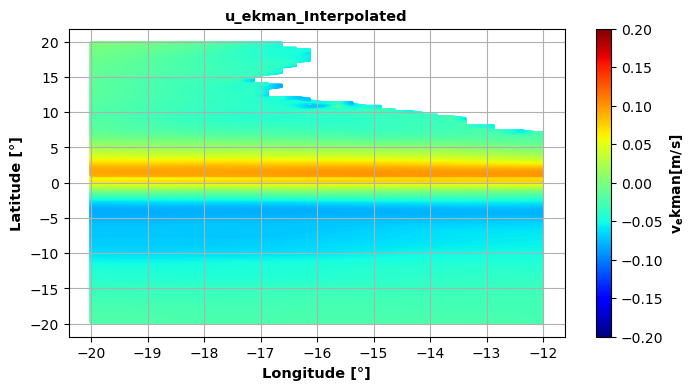

In [15]:
lat_c = latitude_cmems
lon_c = longitude_cmems

# Créer une grille des coordonnées nouvelles
lat_new = np.arange(-20,  20, 1/60)
lon_new = np.arange(-20,  -12, 1/60)

# Créer une grille 2D pour lat_new et lon_new
grid_x, grid_y = np.meshgrid(lon_new, lat_new)

# Créer une grille 2D pour les coordonnées d'origine
lon_grid, lat_grid = np.meshgrid(lon_c, lat_c)

# Interpoler les données
v_ekman_interp = griddata((lon_grid.flatten(), lat_grid.flatten()), cmems_ve_mean.flatten(), (grid_x, grid_y), method='linear')

# Plot des données interpolées
plt.figure(figsize=(8, 4))
plt.scatter(grid_x, grid_y, c=v_ekman_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label=r'$\mathbf{v_ekman [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('u_ekman_Interpolated', fontsize=10.5, fontweight='bold')
plt.show()

## Correlation test

### Filtering out outlier values

In [16]:
# Créer un masque logique pour les valeurs valides
valid_indice_swot = (vgosa_swot_interp <= 1.1) & (vgosa_swot_interp >= -1.1)
valid_indice_cmems = (vgosa_cmems_interp <= 1.1) & (vgosa_cmems_interp >= -1.1)

# Appliquer le masque pour filtrer directement, en remplaçant les valeurs non valides par NaN
vgosa_swot_filte = np.where(valid_indice_swot, vgosa_swot_interp, np.nan)
vgosa_cmems_filte = np.where(valid_indice_cmems, vgosa_cmems_interp, np.nan)

### Moving average over different windows

In [17]:
# Créer une matrice 2400x480 remplie de NaN
vgosa_swot_filter = np.full((2400, 480), np.nan)

fenetre = 40
# fenetre[7 15 30 40 60 65]  =>  coefficient_correlation [0.23  0.30 0.39 0.40 0.39 0.80]

# Boucle à travers chaque élément de la matrice
for i in range(2400):
    for j in range(480):
        # Ne faire l'opération que si l'élément actuel n'est pas NaN
        if not np.isnan(vgosa_swot_filte[i, j]):
            # Déterminer les indices de découpage, en tenant compte des limites
            i_min = max(0, i - fenetre)
            i_max = min(2400, i + fenetre)
            j_min = max(0, j - fenetre)
            j_max = min(480, j + fenetre)

            # Extraire la sous-matrice
            sub_matrix = vgosa_swot_filte[i_min:i_max, j_min:j_max]
            
            # Calculer la médiane en ignorant NaN
            median_value = np.nanmedian(sub_matrix)
            
            # Vérifier si la valeur calculée est différente de NaN avant d'affecter la valeur
            if not np.isnan(median_value):
                vgosa_swot_filter[i, j] = median_value

## Test 

Corrélation de Pearson: 0.38987075135555005
Valeur de p (p-value): 0.0


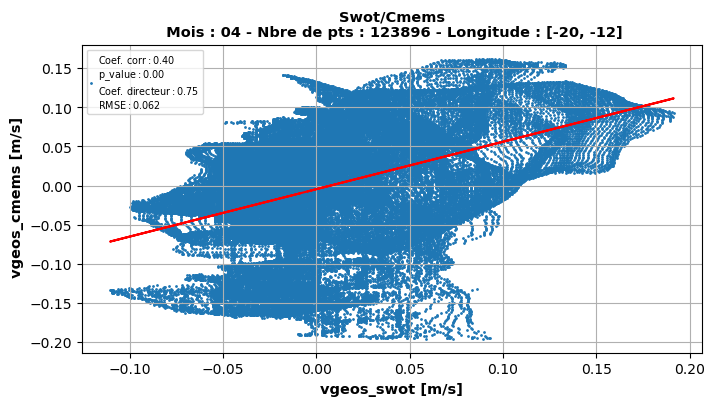

In [18]:
# Convert lists to NumPy arrays
vgosa_swot = vgosa_swot_filter.flatten()
vgosa_cmems = vgosa_cmems_filte.flatten()

# Supprimer les lignes où x et y contiennent les NaN  
mask = ~np.isnan(vgosa_swot) & ~np.isnan(vgosa_cmems)
vgosa_swot_clean = vgosa_swot[mask]
vgosa_cmems_clean = vgosa_cmems[mask]

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(vgosa_swot_clean, vgosa_cmems_clean)

# Calcul de la régression linéaire
coefficients = np.polyfit(vgosa_swot_clean, vgosa_cmems_clean, 1)
p = np.poly1d(coefficients) # p = 0.75

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((vgosa_swot_clean - vgosa_cmems_clean)**2)) # r = 0.062

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

slope, intercept, _, _, _ = linregress( vgosa_swot_clean,vgosa_cmems_clean)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(vgosa_swot_clean, vgosa_cmems_clean, s=1)

plt.plot(vgosa_swot_clean, slope*vgosa_swot_clean + intercept, color='red', label='Linear Regression')

plt.xlabel('vgeos_swot [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel(' vgeos_cmems [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.40$' + '\n'
    r'$\text{p_value} : 0.00$' + '\n'
    r'$\text{Coef. directeur} : 0.75$' + '\n'
    r'$\text{RMSE} : 0.062$'
)
# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Swot/Cmems\n Mois : 04 - Nbre de pts : 123896 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.show()

## Time series

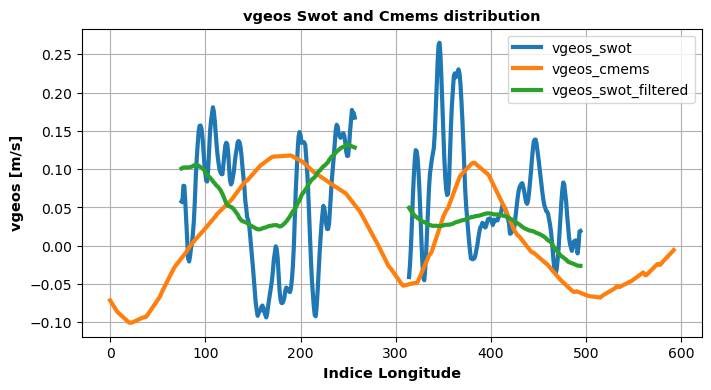

In [19]:
j=100
plt.figure(figsize=(8, 4))
plt.plot(vgosa_swot_filte[1800:2400,j], label ='vgeos_swot', linewidth=3)
plt.plot(vgosa_cmems_filte[1800:2400,j], label ='vgeos_cmems', linewidth=3)
plt.plot(vgosa_swot_filter[1800:2400,j], label ='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'vgeos Swot and Cmems distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show()

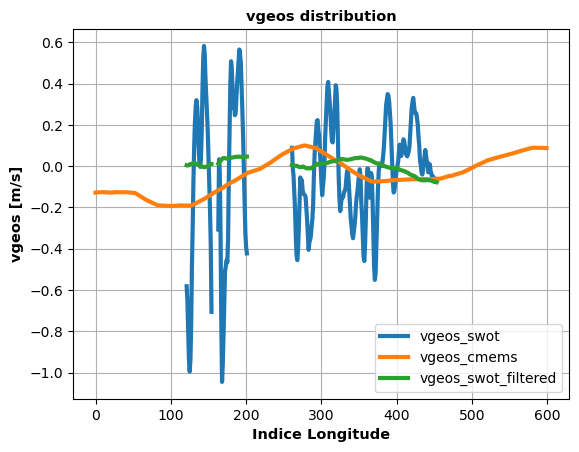

In [20]:
j=200
plt.plot(vgosa_swot_filte[1200:1800,j], label ='vgeos_swot', linewidth=3)
plt.plot(vgosa_cmems_filte[1200:1800,j], label ='vgeos_cmems', linewidth=3)
plt.plot(vgosa_swot_filter[1200:1800,j], label ='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'vgeos distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show()

## CMEMS and Drifter

### Read drifter data 

In [21]:
fn='./drifter_current.nc';
ds_w=xr.open_dataset(fn);

ve_curr = ds_w.ve.values
vn_curr = ds_w.vn.values
lon = ds_w.longitude.values
lat = ds_w.latitude.values
time = ds_w.time.values

data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr
}

df = pd.DataFrame(data)
df =df[12971:13366]

## Let's plot u_drifter et v_drifter

## u_drifter

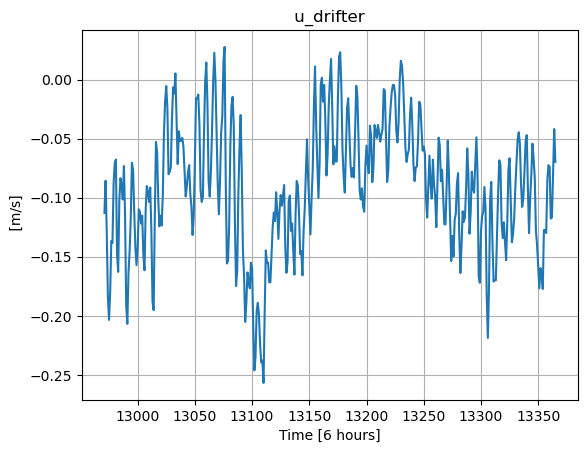

In [22]:
plt.plot(df['ve'] )
plt.title(' u_drifter ')
plt.xlabel('Time [6 hours]')
plt.ylabel(' [m/s]')
plt.grid(True)

## v_drifter

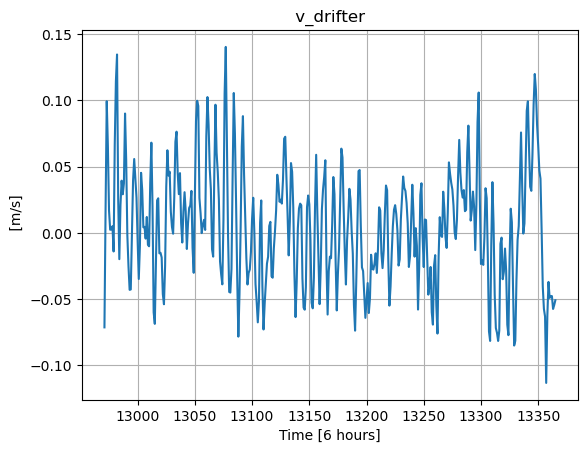

In [23]:
plt.plot(df['vn'] )
plt.title(' v_drifter ')
plt.xlabel('Time [6 hours]')
plt.ylabel(' [m/s]')
plt.grid(True)

## Drifter trajectory

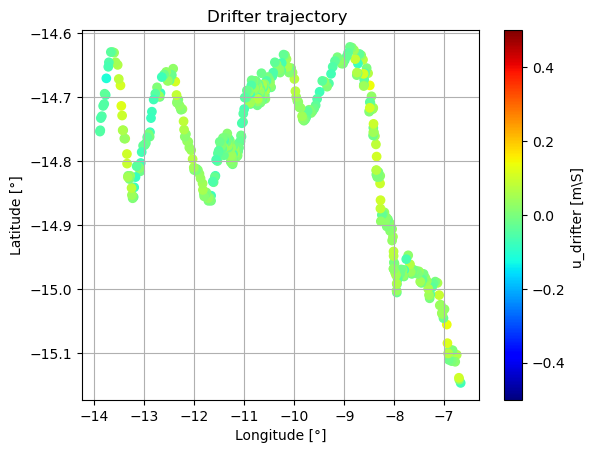

In [24]:
plt.scatter(df['longitude'], df['latitude'], c= df['vn'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')
plt.title('Drifter trajectory ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='u_drifter [m\S] ')

### Application of a linear Hanning filter at a 24-hour resolution.

## Filtration

In [25]:
# Créer un masque logique pour les valeurs valides
valid_indice_ve = (df.ve.values <= 1.1) & (df.ve.values >= -1.1)
valid_indice_vn = (df.vn.values <= 1.1) & (df.vn.values >= -1.1)

# Appliquer le masque pour filtrer directement, en remplaçant les valeurs non valides par NaN
ve_drifter_ve = np.where(valid_indice_ve, df.ve.values , np.nan)
vn_drifter_vn = np.where(valid_indice_vn, df.vn.values, np.nan)

In [26]:
time = np.array(df.time.values)   
current_data = np.array(ve_drifter_ve)   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

time = np.array(df.time.values)   
current_data = np.array(vn_drifter_vn)   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter  

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2267474566.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window
C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_24920\2267474566.py:18: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Let's plot u_drifter aftered

## u_drifter

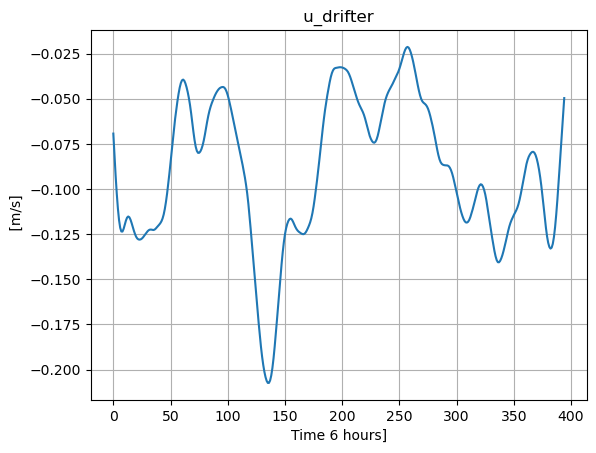

In [27]:
plt.plot(ve_filter_Han)
plt.title(' u_drifter ')
plt.xlabel('Time 6 hours]')
plt.ylabel(' [m/s]')
plt.grid(True)

## v_drifter

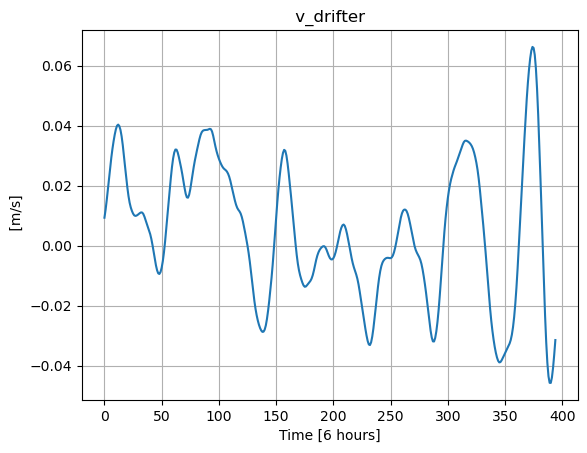

In [28]:
plt.plot(vn_filter_Han)
plt.title(' v_drifter ')
plt.xlabel('Time [6 hours]')
plt.ylabel(' [m/s]')
plt.grid(True)

## Daily averages of currents

In [29]:
index = pd.to_datetime(df.time.values)

s1=pd.Series(ve_filter_Han,index=index)
s2=pd.Series(vn_filter_Han,index=index)
s3 = pd.Series(df.longitude.values,index=index)
s4 = pd.Series(df.latitude.values,index=index)
s5 = pd.Series(df.time.values,index=index)

mean_ve_w = s1.resample('24H').mean()
mean_vn_w = s2.resample('24H').mean()
mean_lon_w = s3.resample('24H').mean()
mean_lat_w = s4.resample('24H').mean()
mean_time_w = s5.resample('24H').mean()

data = {
    'mean_ve_w': mean_ve_w,
    'mean_vn_w' : mean_vn_w,
    'mean_lat_w'     : mean_lat_w,
    'mean_lon_w'       : mean_lon_w,
    'mean_time_w'       : mean_time_w
}

DF = pd.DataFrame(data)
df_reset = DF.reset_index(drop=True)

# Indices spécifiques à supprimer
indices_to_remove = [48, 49, 50, 61]

# Supprimer les lignes correspondant à ces indices
filtered_df =DF

## Find the indices of drifter longitudes and latitudes in CMEMS

In [30]:
lon_cmems = lat_new
lat_cmems = lon_new

# Trouver les indices des latitudes les plus proches
indice_lat_c = []
indice_lon_c = []

for search_lat in filtered_df.mean_lat_w.values:
    differences = np.abs(lat_cmems - search_lat)
    closest_indice_lat = np.argmin(differences)
    indice_lat_c.append(closest_indice_lat)
                                                          
for search_lon in filtered_df.mean_lon_w.values:
    differencs = np.abs(lon_cmems - search_lon)
    closest_indice_lon = np.argmin(differencs)
    indice_lon_c.append(closest_indice_lon)

## Searching for current cmems corresponding to the indices

In [31]:
ugosa_cmems = (ugosa_cmems_interp + u_ekman_interp)[ indice_lon_c,indice_lat_c]
vgosa_cmems = (vgosa_cmems_interp + v_ekman_interp)[indice_lon_c,indice_lat_c]

Df_dc = pd.DataFrame({
    'mean_ve_w': filtered_df.mean_ve_w.values,
    'mean_vn_w': filtered_df.mean_vn_w.values,
    'mean_lon_w': filtered_df.mean_lon_w.values,
    'mean_lat_w': filtered_df.mean_lat_w.values,
    'mean_time_w': filtered_df.mean_time_w.values,
    'ugosa_cmems': ugosa_cmems.flatten(),
    'vgosa_cmems': vgosa_cmems.flatten()
})

## Drifter trajectory per day

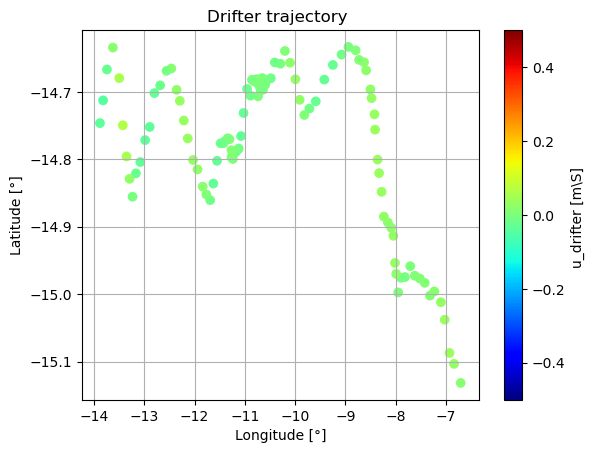

In [32]:
plt.scatter(Df_dc['mean_lon_w'], Df_dc['mean_lat_w'], c= Df_dc['mean_vn_w'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')
plt.title('Drifter trajectory ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='u_drifter [m\S] ')

##  Correlation

## zonal components

In [33]:
mask = ~np.isnan(Df_dc['ugosa_cmems'])
u_drifter_mask = Df_dc['mean_ve_w'][mask]
ugeos_cmems_mask = Df_dc['ugosa_cmems'][mask]
time_cmems_mask_u = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_cmems_mask )[0, 1]
correlation_coefficient

0.2017556003675279

## meridional components

In [34]:
mask = ~np.isnan(Df_dc['mean_vn_w']) & ~np.isnan(Df_dc['vgosa_cmems'])
v_drifter_mask = Df_dc['mean_vn_w'][mask]
vgeos_cmems_mask = Df_dc['vgosa_cmems'][mask]
time_cmems_mask_v = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_cmems_mask )[0, 1]
correlation_coefficient

-0.3095870083337097

## Let's Plot time series

## zonal components

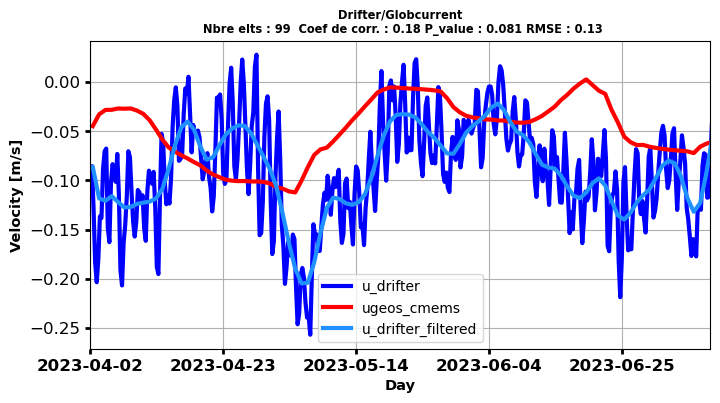

In [35]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))

plt.plot( df['time'], df['ve'], color='Blue', label='u_drifter', linewidth=3)
plt.plot(time_cmems_mask_u, ugeos_cmems_mask, color='red', label='ugeos_cmems', linewidth=3)
plt.plot(time_cmems_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : 0.18 P_value : 0.081 RMSE : 0.13'
plt.title(title_text, fontsize=8.2, fontweight='bold')

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-04-02'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-04-02', end='2023-07-09', freq='504H'))
ax.set_xticklabels(pd.date_range(start='2023-04-02', end='2023-07-09', freq='504H').strftime('%Y-%m-%d'), rotation=0)

# plt.savefig("fig16 mode.png")
plt.show()

## meridional components

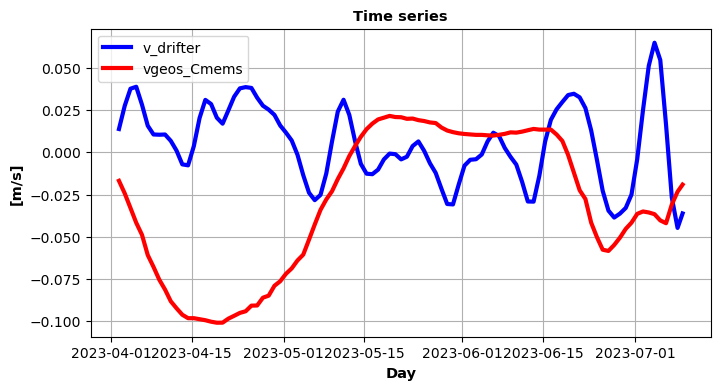

In [36]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.plot(time_cmems_mask_v, v_drifter_mask, color='Blue', label='v_drifter', linewidth=3)
plt.plot(time_cmems_mask_v, vgeos_cmems_mask, color='red', label='vgeos_Cmems', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('[m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show()

## regression

## zonal components

Corrélation de Pearson: 0.20175560036752782
Valeur de p (p-value): 0.045221121451590914


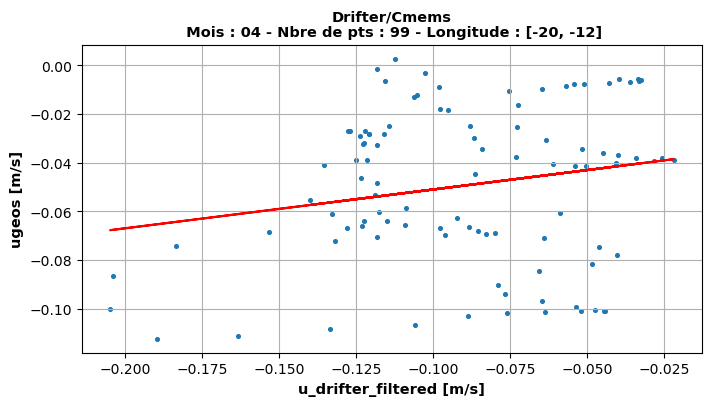

In [37]:
# Calculation of Pearson correlation
correlation, p_value = pearsonr(u_drifter_mask, ugeos_cmems_mask)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( u_drifter_mask, ugeos_cmems_mask)

# Calcul de la régression linéaire
coefficients = np.polyfit(u_drifter_mask, ugeos_cmems_mask, 1)
p = np.poly1d(coefficients) # p = 1.01

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((u_drifter_mask - ugeos_cmems_mask)**2)) # rmse = 0.063

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(u_drifter_mask, ugeos_cmems_mask, s=7)
plt.plot(u_drifter_mask, slope*u_drifter_mask + intercept, color='red', label='Linear Regression')
plt.xlabel('u_drifter_filtered [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.66$' + '\n'
    r'$\text{p_value} : 3.70e-13$' + '\n'
    r'$\text{Coef. directeur} :  2.26$' + '\n'
    r'$\text{RMSE} : 0.11$'
)

# Affichage de la légende
# plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Cmems\n Mois : 04 - Nbre de pts : 99 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig21 mode.png")
plt.show()

## meridional components

Corrélation de Pearson: -0.30958700833370956
Valeur de p (p-value): 0.0018194993288312502


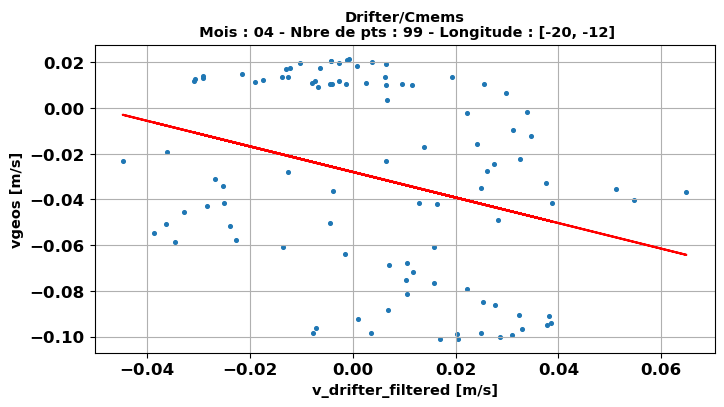

In [38]:
# Calculation of Pearson correlation
correlation, p_value = pearsonr(v_drifter_mask, vgeos_cmems_mask)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( v_drifter_mask, vgeos_cmems_mask)

# Calcul de la régression linéaire
coefficients = np.polyfit(v_drifter_mask, vgeos_cmems_mask, 1)
p = np.poly1d(coefficients) # p = 1.01

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((v_drifter_mask - vgeos_cmems_mask)**2)) # rmse = 0.063

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(v_drifter_mask, vgeos_cmems_mask, s=7)
plt.plot(v_drifter_mask, slope*v_drifter_mask + intercept, color='red', label='Linear Regression')
plt.xlabel('v_drifter_filtered [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.66$' + '\n'
    r'$\text{p_value} : 3.70e-13$' + '\n'
    r'$\text{Coef. directeur} :  2.26$' + '\n'
    r'$\text{RMSE} : 0.11$'
)

# Affichage de la légende
# plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Cmems\n Mois : 04 - Nbre de pts : 99 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig21 mode.png")
plt.show()

## SWOT and Drifter

## Searching for current swot corresponding to the indices

In [39]:
lon_swot= lat_new
lat_swot = lon_new

# Trouver les indices des latitudes les plus proches
indice_lat_s = []
indice_lon_s = []

for search_lat in filtered_df.mean_lat_w.values:
    differences = np.abs(lat_swot - search_lat)
    closest_indice_lat = np.argmin(differences)
    indice_lat_s.append(closest_indice_lat)
                                                          
for search_lon in filtered_df.mean_lon_w.values:
    differencs = np.abs(lon_swot - search_lon)
    closest_indice_lon = np.argmin(differencs)
    indice_lon_s.append(closest_indice_lon)

## Searching for current swot corresponding to the indices

In [40]:
ugosa_swot = (ugosa_swot_interp + u_ekman_interp)[ indice_lon_s,indice_lat_s]
vgosa_swot = (vgosa_swot_interp + v_ekman_interp)[indice_lon_s,indice_lat_s]



Df_ds = pd.DataFrame({
    'mean_ve_w': filtered_df.mean_ve_w.values,
    'mean_vn_w': filtered_df.mean_vn_w.values,
    'mean_time_w': filtered_df.mean_time_w.values,
    'ugosa_swot': ugosa_swot.flatten(),
    'vgosa_swot': vgosa_swot.flatten()
})

## Correlation

## zonal components

In [41]:
mask = ~np.isnan(Df_ds['mean_ve_w']) & ~np.isnan(Df_ds['ugosa_swot'])
u_drifter_mask = Df_ds['mean_ve_w'][mask]
ugeos_swot_mask = Df_ds['ugosa_swot'][mask]
time_swot_mask_u = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_swot_mask )[0, 1]
correlation_coefficient

0.35312332749047226

## meridional components

In [42]:
mask = ~np.isnan(Df_ds['mean_vn_w']) & ~np.isnan(Df_ds['vgosa_swot'])
v_drifter_mask = Df_ds['mean_vn_w'][mask]
vgeos_swot_mask = Df_ds['vgosa_swot'][mask]
time_swot_mask_v = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_swot_mask )[0, 1]
correlation_coefficient

-0.21599915998918162

## Let's Plot time series

## zonal components

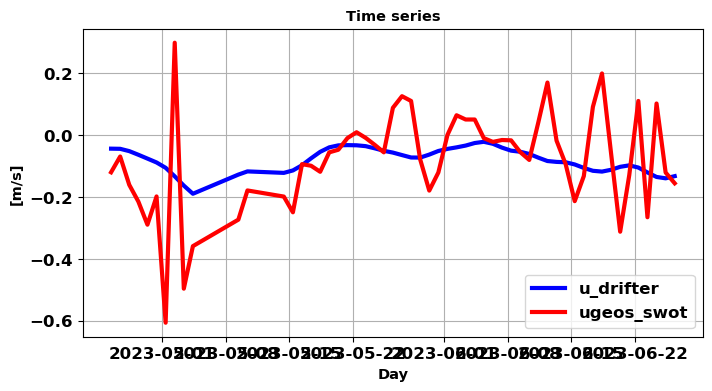

In [43]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.plot(time_swot_mask_u, u_drifter_mask, color='Blue', label='u_drifter', linewidth=3)
plt.plot(time_swot_mask_u, ugeos_swot_mask, color='red', label='ugeos_swot', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('[m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show() 

## Meridional components

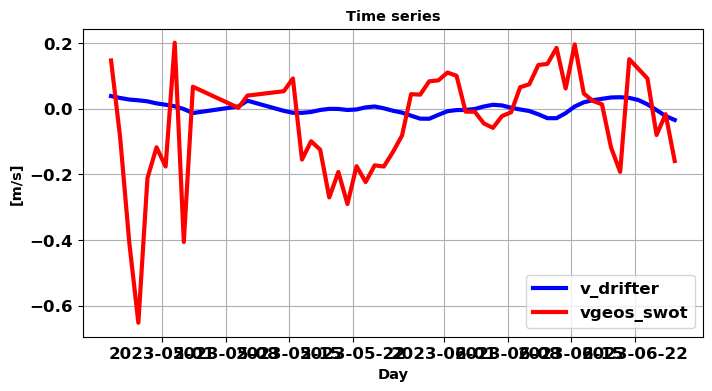

In [44]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.plot(time_swot_mask_v, v_drifter_mask, color='Blue', label='v_drifter', linewidth=3)
plt.plot(time_swot_mask_v, vgeos_swot_mask, color='red', label='vgeos_swot', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('[m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show() 

## Temporal filtering 

### ugeos_swot case

In [45]:
data = np.full(56, np.nan)

# Définir la taille de la fenêtre
fenetre = 2

# Créer un tableau pour stocker les données lissées
u_swot_smoothed = np.copy(ugeos_swot_mask)

# Boucle à travers chaque jour de la série temporelle
for i in range(56):
    # Déterminer les indices de découpage temporels, en tenant compte des limites
    i_min = max(0, i - fenetre)
    i_max = min(56, i + fenetre)  
    
    # Extraire la sous-séquence pour les indices spécifiés
    sub_sequence = ugeos_swot_mask[i_min:i_max]
    
    # Calculer la médiane en ignorant NaN
    median_value = np.nanmedian(sub_sequence)
    
    # Vérifier si la valeur calculée est différente de NaN avant d'affecter la valeur
    if not np.isnan(median_value):
        u_swot_smoothed[i] = median_value

### vgeos_swot case

In [46]:
data = np.full(56, np.nan)

# Définir la taille de la fenêtre
fenetre = 2

# Créer un tableau pour stocker les données lissées
v_swot_smoothed = np.copy(vgeos_swot_mask)

# Boucle à travers chaque jour de la série temporelle
for i in range(56):
    # Déterminer les indices de découpage temporels, en tenant compte des limites
    i_min = max(0, i - fenetre)
    i_max = min(56, i + fenetre)  
    
    # Extraire la sous-séquence pour les indices spécifiés
    sub_sequence = vgeos_swot_mask[i_min:i_max]
    
    # Calculer la médiane en ignorant NaN
    median_value = np.nanmedian(sub_sequence)
    
    # Vérifier si la valeur calculée est différente de NaN avant d'affecter la valeur
    if not np.isnan(median_value):
        v_swot_smoothed[i] = median_value

## Time series after temporal filtering

### Zonal case

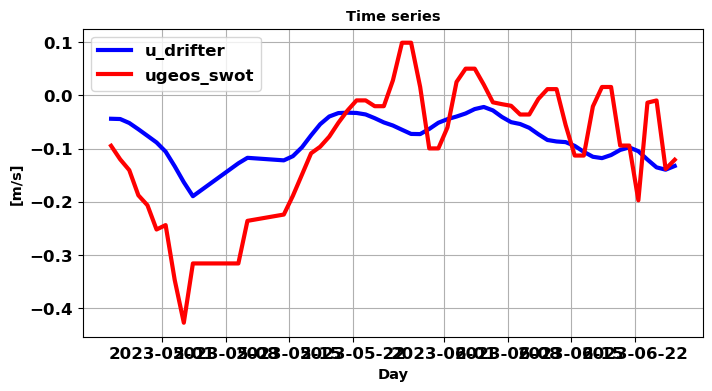

In [47]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.plot(time_swot_mask_u, u_drifter_mask, color='Blue', label='u_drifter', linewidth=3)
plt.plot(time_swot_mask_u, u_swot_smoothed, color='red', label='ugeos_swot', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('[m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show() 

[Text(19449.0, 0, '2023-04-02'),
 Text(19470.0, 0, '2023-04-23'),
 Text(19491.0, 0, '2023-05-14'),
 Text(19512.0, 0, '2023-06-04'),
 Text(19533.0, 0, '2023-06-25')]

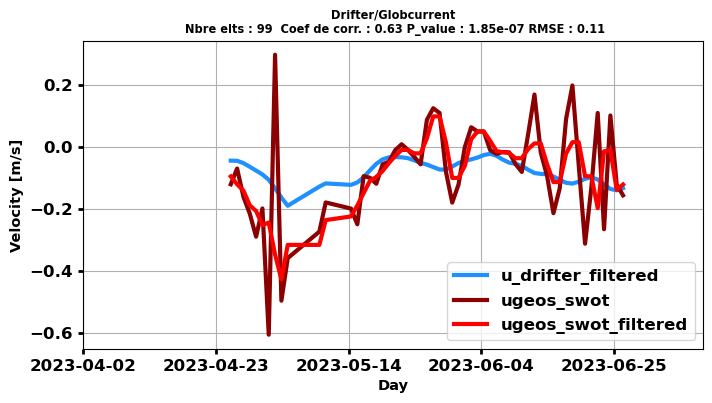

In [48]:
plt.figure(figsize=(8, 4))

plt.plot(time_swot_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)
plt.plot(time_swot_mask_u, ugeos_swot_mask, color='#8B0000', label='ugeos_swot', linewidth=3)
plt.plot(time_swot_mask_u, u_swot_smoothed, color='red', label='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : 0.63 P_value : 1.85e-07 RMSE : 0.11'
plt.title(title_text, fontsize=8.2, fontweight='bold')

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-04-02'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-04-02', end='2023-07-09', freq='504H'))
ax.set_xticklabels(pd.date_range(start='2023-04-02', end='2023-07-09', freq='504H').strftime('%Y-%m-%d'), rotation=0)


### Meridional case

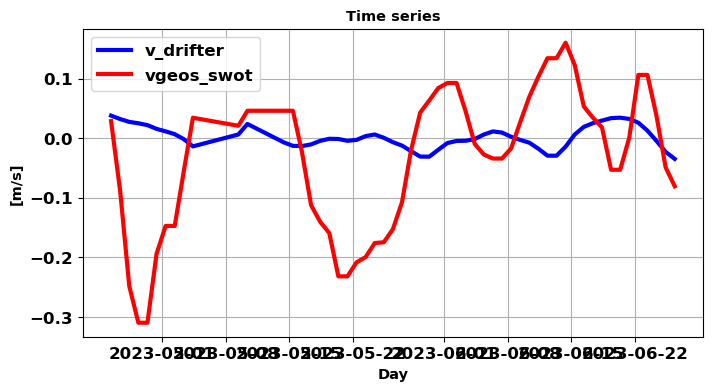

In [49]:
# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.plot(time_swot_mask_v, v_drifter_mask, color='Blue', label='v_drifter', linewidth=3)
plt.plot(time_swot_mask_v, v_swot_smoothed, color='red', label='vgeos_swot', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('[m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')

plt.grid(True)
plt.legend()
# plt.savefig("fig16 mode.png")
plt.show() 

## regression

## zonal components

Corrélation de Pearson: 0.5997650668282819
Valeur de p (p-value): 1.0348888214777268e-06


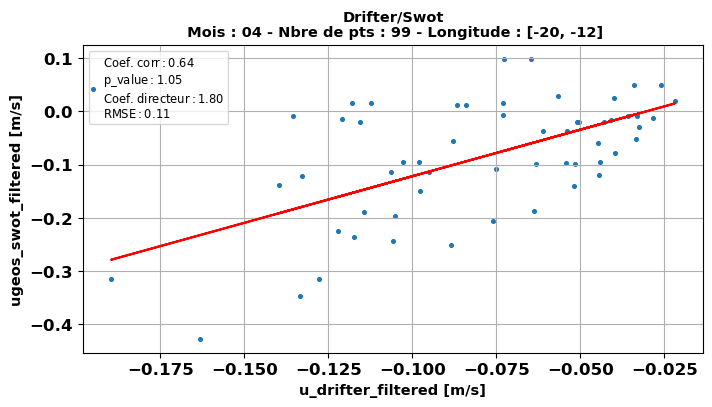

In [50]:
# Calculation of Pearson correlation
correlation, p_value = pearsonr(u_drifter_mask, u_swot_smoothed)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( u_drifter_mask, u_swot_smoothed)

# Calcul de la régression linéaire
coefficients = np.polyfit(u_drifter_mask, u_swot_smoothed, 1)
p = np.poly1d(coefficients) # p = 1.01

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((u_drifter_mask - u_swot_smoothed)**2)) # rmse = 0.063

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(u_drifter_mask, u_swot_smoothed, s=7)
plt.plot(u_drifter_mask, slope*u_drifter_mask + intercept, color='red', label='Linear Regression')
plt.xlabel('u_drifter_filtered [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos_swot_filtered [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.64$' + '\n'
    r'$\text{p_value} : 1.05$' + '\n'
    r'$\text{Coef. directeur} :  1.80$' + '\n'
    r'$\text{RMSE} : 0.11$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Swot\n Mois : 04 - Nbre de pts : 99 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig21 mode.png")
plt.show()

## meridional components

Corrélation de Pearson: -0.26348026475842373
Valeur de p (p-value): 0.04975587018935365


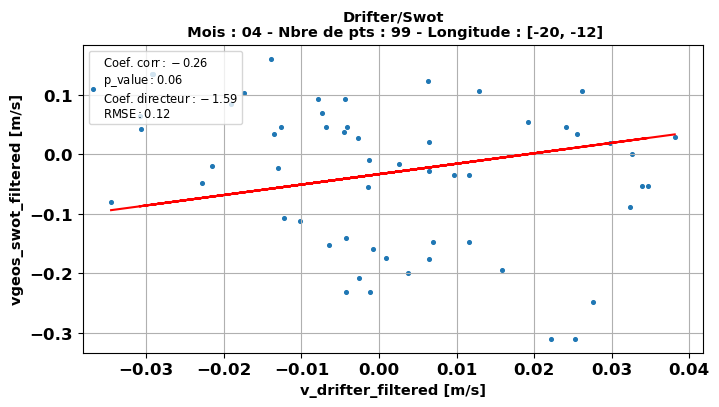

In [51]:
# Calculation of Pearson correlation
correlation, p_value = pearsonr(v_drifter_mask, v_swot_smoothed)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slop0e, intercept, _, _, _ = linregress( v_drifter_mask, v_swot_smoothed)

# Calcul de la régression linéaire
coefficients = np.polyfit(v_drifter_mask, v_swot_smoothed, 1)
p = np.poly1d(coefficients) # p = -1.58

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((v_drifter_mask - v_swot_smoothed)**2)) # rmse = 0.12

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(v_drifter_mask, v_swot_smoothed, s=7)
plt.plot(v_drifter_mask, slope*v_drifter_mask + intercept, color='red', label='Linear Regression')
plt.xlabel('v_drifter_filtered [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos_swot_filtered [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : -0.26$' + '\n'
    r'$\text{p_value} : 0.06$' + '\n'
    r'$\text{Coef. directeur} :  -1.59$' + '\n'
    r'$\text{RMSE} : 0.12$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Swot\n Mois : 04 - Nbre de pts : 99 - Longitude : [-20, -12]'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig21 mode.png")
plt.show()

## Resume

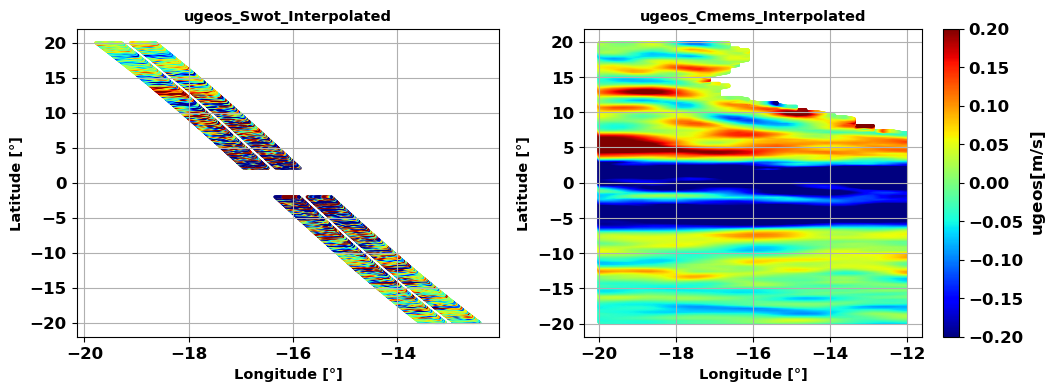

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
# plt.scatter(grid_x, grid_y, swot_new, vmin=-0.2, vmax=0.2 )
plt.scatter(grid_x,grid_y,c=ugosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

# plt.colorbar(label=r'$\mathbf{ugeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('ugeos_Swot_Interpolated', fontsize=10.5, fontweight='bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique
plt.scatter(grid_x, grid_y, c=ugosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label=r'$\mathbf{ugeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('ugeos_Cmems_Interpolated', fontsize=10.5, fontweight='bold')
plt.savefig("fig4_mode_projection.png", bbox_inches='tight')  
plt.show()

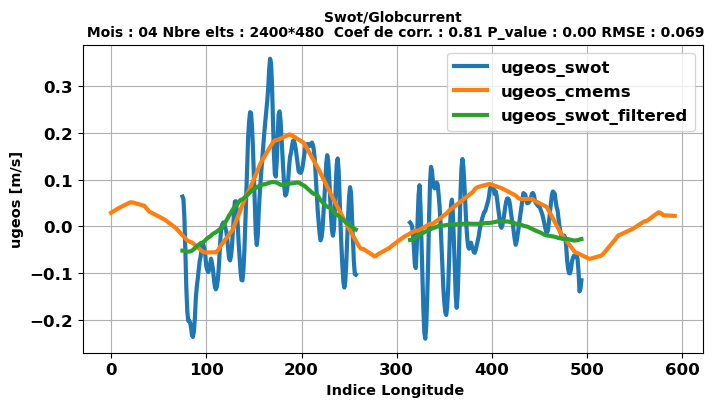

In [53]:
plt.figure(figsize=(8, 4))

j=100
plt.plot(ugosa_swot_filte[1800:2400,j], label ='ugeos_swot', linewidth=3)
plt.plot(ugosa_cmems_filte[1800:2400,j], label ='ugeos_cmems', linewidth=3)
plt.plot(ugosa_swot_filter[1800:2400,j], label ='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel(' Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'ugeos distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

# Titre
title_text = 'Swot/Globcurrent\n Mois : 04 Nbre elts : 2400*480  Coef de corr. : 0.81 P_value : 0.00 RMSE : 0.069'
plt.title(title_text, fontsize=10, fontweight='bold')

plt.grid(True)
plt.legend()
plt.savefig("fig5_mode_projection.png", bbox_inches='tight')  
plt.show()

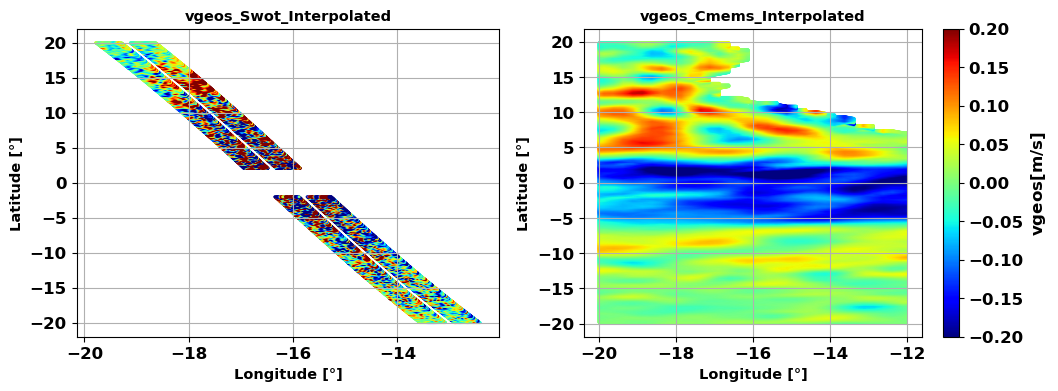

In [54]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.scatter(grid_x,grid_y,c=vgosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

# plt.colorbar(label=r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Swot_Interpolated', fontsize=10.5, fontweight='bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique
plt.scatter(grid_x, grid_y, c=vgosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label= r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Cmems_Interpolated', fontsize=10.5, fontweight='bold')
plt.savefig("fig6_mode_projection.png", bbox_inches='tight')  
plt.show()

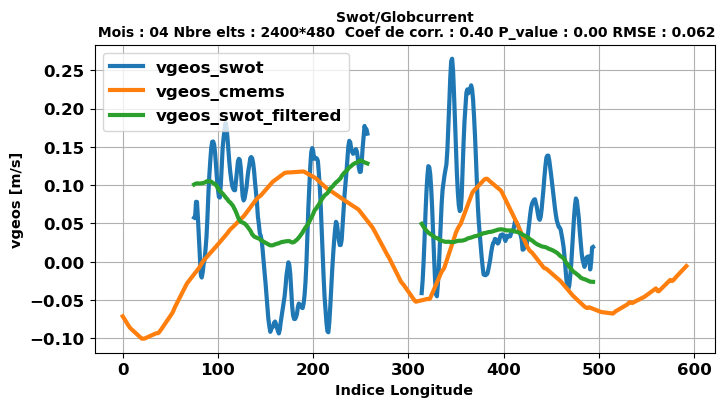

In [55]:
plt.figure(figsize=(8, 4))

j=100
plt.plot(vgosa_swot_filte[1800:2400,j], label ='vgeos_swot', linewidth=3)
plt.plot(vgosa_cmems_filte[1800:2400,j], label ='vgeos_cmems', linewidth=3)
plt.plot(vgosa_swot_filter[1800:2400,j], label ='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'vgeos distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

# Titre
title_text = 'Swot/Globcurrent\n Mois : 04 Nbre elts : 2400*480  Coef de corr. : 0.40 P_value : 0.00 RMSE : 0.062'
plt.title(title_text, fontsize=10, fontweight='bold')

plt.grid(True)
plt.legend()
plt.savefig("fig7_mode_projection.png", bbox_inches='tight')  
plt.show()

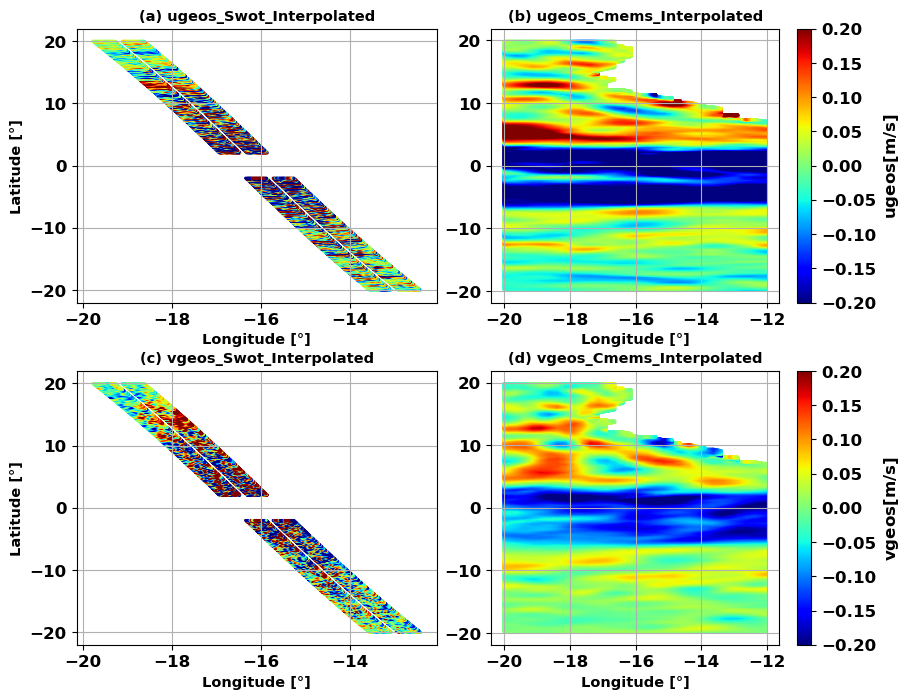

In [56]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)  # Premier sous-graphique
# plt.scatter(grid_x, grid_y, swot_new, vmin=-0.2, vmax=0.2 )
plt.scatter(grid_x,grid_y,c=ugosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

# plt.colorbar(label=r'$\mathbf{ugeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('(a) ugeos_Swot_Interpolated', fontsize=10.5, fontweight='bold')

plt.subplot(2, 2, 2)  # Premier sous-graphique
plt.scatter(grid_x, grid_y, c=ugosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label=r'$\mathbf{ugeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
# plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('(b) ugeos_Cmems_Interpolated', fontsize=10.5, fontweight='bold')

plt.subplot(2, 2, 3)  # Premier sous-graphique
plt.scatter(grid_x,grid_y,c=vgosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')

# plt.colorbar(label=r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('(c) vgeos_Swot_Interpolated', fontsize=10.5, fontweight='bold')

plt.subplot(2, 2, 4)  # Premier sous-graphique
plt.scatter(grid_x, grid_y, c=vgosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.colorbar(label= r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
# plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('(d) vgeos_Cmems_Interpolated', fontsize=10.5, fontweight='bold')
plt.subplots_adjust(hspace=0.25, wspace=0.15)  # Ajuster hspace et wspace si nécessaire
plt.savefig("fig8_mode_projection.png", bbox_inches='tight')  
plt.show()

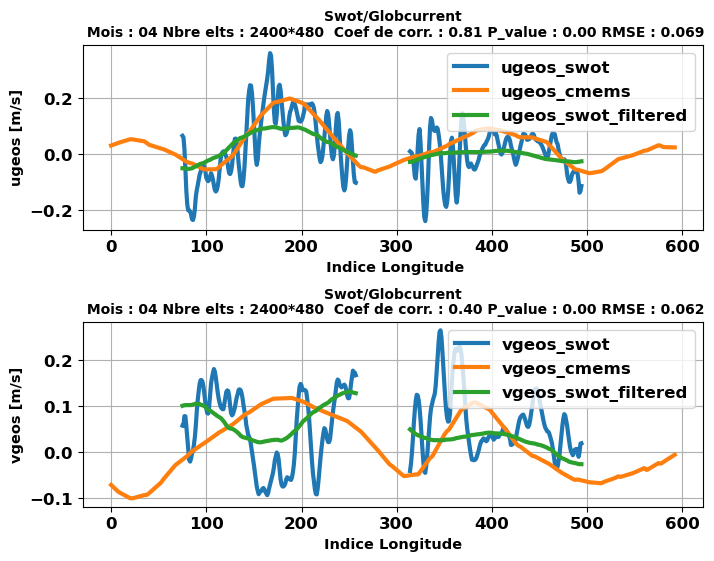

In [57]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)  # Premier sous-graphique

j=100
plt.plot(ugosa_swot_filte[1800:2400,j], label ='ugeos_swot', linewidth=3)
plt.plot(ugosa_cmems_filte[1800:2400,j], label ='ugeos_cmems', linewidth=3)
plt.plot(ugosa_swot_filter[1800:2400,j], label ='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel(' Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'ugeos distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

# Titre
title_text = 'Swot/Globcurrent\n Mois : 04 Nbre elts : 2400*480  Coef de corr. : 0.81 P_value : 0.00 RMSE : 0.069'
plt.title(title_text, fontsize=10, fontweight='bold')

plt.grid(True)
plt.legend(loc='best')

plt.subplot(2, 1, 2)  # Premier sous-graphique

j=100
plt.plot(vgosa_swot_filte[1800:2400,j], label ='vgeos_swot', linewidth=3)
plt.plot(vgosa_cmems_filte[1800:2400,j], label ='vgeos_cmems', linewidth=3)
plt.plot(vgosa_swot_filter[1800:2400,j], label ='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Indice Longitude', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'vgeos distribution'
plt.title(title_text, fontsize=10.5, fontweight='bold')

# Titre
title_text = 'Swot/Globcurrent\n Mois : 04 Nbre elts : 2400*480  Coef de corr. : 0.40 P_value : 0.00 RMSE : 0.062'
plt.title(title_text, fontsize=10, fontweight='bold')

plt.grid(True)
plt.legend(loc='best')
plt.subplots_adjust(hspace=0.5)  # Ajustez la valeur de hspace selon vos besoins

plt.savefig("fig11_mode_projection.png", bbox_inches='tight')  
plt.show()

In [58]:
mask = ~np.isnan(Df_dc['ugosa_cmems'])
u_drifter_mask = Df_dc['mean_ve_w'][mask]
ugeos_cmems_mask = Df_dc['ugosa_cmems'][mask]
time_cmems_mask_u = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_cmems_mask )[0, 1]
correlation_coefficient

mask = ~np.isnan(Df_dc['mean_vn_w']) & ~np.isnan(Df_dc['vgosa_cmems'])
v_drifter_mask = Df_dc['mean_vn_w'][mask]
vgeos_cmems_mask = Df_dc['vgosa_cmems'][mask]
time_cmems_mask_v = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_cmems_mask )[0, 1]
correlation_coefficient

-0.3095870083337097

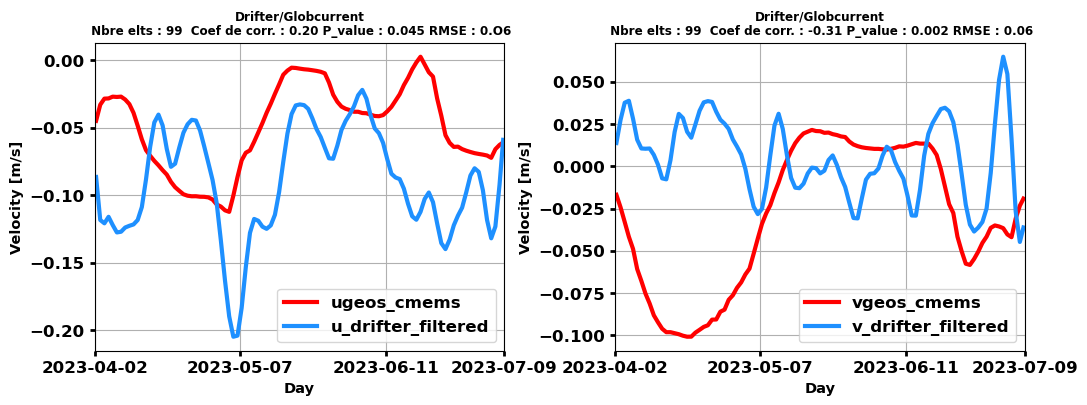

In [59]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
# plt.plot( df['time'], df['ve'], color='Blue', label='u_drifter', linewidth=3)
plt.plot(time_cmems_mask_u, ugeos_cmems_mask, color='red', label='ugeos_cmems', linewidth=3)
plt.plot(time_cmems_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : 0.20 P_value : 0.045 RMSE : 0.O6'
plt.title(title_text, fontsize=8.6, fontweight='bold')

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df['time'].min()
max_date = df['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique

# plt.plot( df['time'], df['vn'], color='Blue', label='v_drifter', linewidth=3)
plt.plot(time_cmems_mask_v, vgeos_cmems_mask, color='red', label='vgeos_cmems', linewidth=3)
plt.plot(time_cmems_mask_v, v_drifter_mask, color='dodgerblue', label='v_drifter_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : -0.31 P_value : 0.002 RMSE : 0.06'
plt.title(title_text, fontsize=8.6, fontweight='bold')

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df['time'].min()
max_date = df['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    
plt.subplots_adjust( wspace=0.27)  # Ajuster hspace et wspace si nécessaire
plt.savefig("fig13_mode_projection.png", bbox_inches='tight')  
plt.show()

In [60]:
mask = ~np.isnan(Df_ds['mean_ve_w']) & ~np.isnan(Df_ds['ugosa_swot'])
u_drifter_mask = Df_ds['mean_ve_w'][mask]
ugeos_swot_mask = Df_ds['ugosa_swot'][mask]
time_swot_mask_u = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_swot_mask )[0, 1]
correlation_coefficient

mask = ~np.isnan(Df_ds['mean_vn_w']) & ~np.isnan(Df_ds['vgosa_swot'])
v_drifter_mask = Df_ds['mean_vn_w'][mask]
vgeos_swot_mask = Df_ds['vgosa_swot'][mask]
time_swot_mask_v = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_swot_mask )[0, 1]
correlation_coefficient

-0.21599915998918162

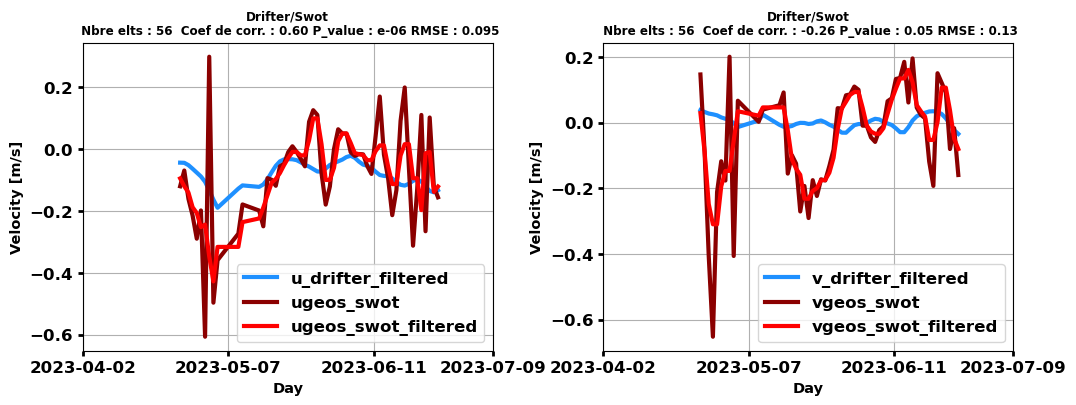

In [61]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
 
plt.plot(time_swot_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)
plt.plot(time_swot_mask_u, ugeos_swot_mask, color='#8B0000', label='ugeos_swot', linewidth=3)
plt.plot(time_swot_mask_u, u_swot_smoothed, color='red', label='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Swot\n Nbre elts : 56  Coef de corr. : 0.60 P_value : e-06 RMSE : 0.095'
plt.title(title_text, fontsize=8.6, fontweight='bold')

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df['time'].min()
max_date = df['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique
 
plt.plot(time_swot_mask_v, v_drifter_mask, color='dodgerblue', label='v_drifter_filtered', linewidth=3)
plt.plot(time_swot_mask_v, vgeos_swot_mask, color='#8B0000', label='vgeos_swot', linewidth=3)
plt.plot(time_swot_mask_v, v_swot_smoothed, color='red', label='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=8.6, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Swot\n Nbre elts : 56  Coef de corr. : -0.26 P_value : 0.05 RMSE : 0.13'
plt.title(title_text, fontsize=8.6, fontweight='bold')

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df['time'].min()
max_date = df['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    
plt.subplots_adjust( wspace=0.27)  # Ajuster hspace et wspace si nécessaire
 
plt.savefig("fig14_mode_projection.png", bbox_inches='tight')  
plt.show()

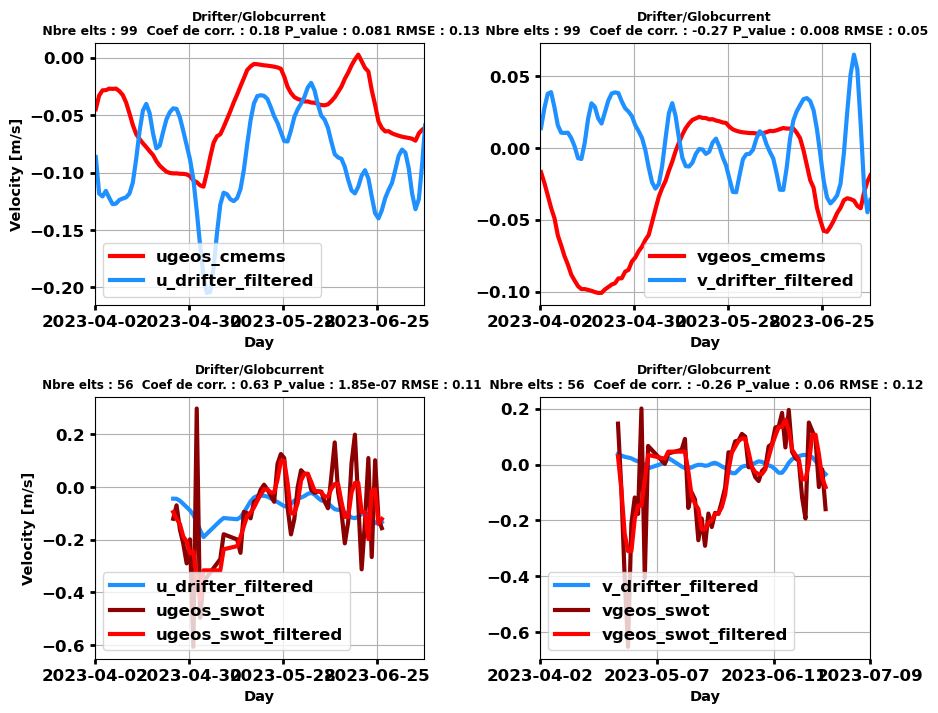

In [62]:
plt.figure(figsize=(10, 8))

mask = ~np.isnan(Df_dc['ugosa_cmems'])
u_drifter_mask = Df_dc['mean_ve_w'][mask]
ugeos_cmems_mask = Df_dc['ugosa_cmems'][mask]
time_cmems_mask_u = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_cmems_mask )[0, 1]
correlation_coefficient

mask = ~np.isnan(Df_dc['mean_vn_w']) & ~np.isnan(Df_dc['vgosa_cmems'])
v_drifter_mask = Df_dc['mean_vn_w'][mask]
vgeos_cmems_mask = Df_dc['vgosa_cmems'][mask]
time_cmems_mask_v = Df_dc['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_cmems_mask )[0, 1]
correlation_coefficient

plt.subplot(2, 2, 1)  # Premier sous-graphique
# plt.plot( df['time'], df['ve'], color='Blue', label='u_drifter', linewidth=3)
plt.plot(time_cmems_mask_u, ugeos_cmems_mask, color='red', label='ugeos_cmems', linewidth=3)
plt.plot(time_cmems_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : 0.18 P_value : 0.081 RMSE : 0.13'
plt.title(title_text, fontsize=9, fontweight='bold')

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-04-02'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H'))
ax.set_xticklabels(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H').strftime('%Y-%m-%d'), rotation=0)

plt.subplot(2, 2, 2)  # Premier sous-graphique

# plt.plot( df['time'], df['vn'], color='Blue', label='v_drifter', linewidth=3)
plt.plot(time_cmems_mask_v, vgeos_cmems_mask, color='red', label='vgeos_cmems', linewidth=3)
plt.plot(time_cmems_mask_v, v_drifter_mask, color='dodgerblue', label='v_drifter_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
# plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 99  Coef de corr. : -0.27 P_value : 0.008 RMSE : 0.05'
plt.title(title_text, fontsize=9, fontweight='bold')

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-04-02'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H'))
ax.set_xticklabels(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H').strftime('%Y-%m-%d'), rotation=0)
  
mask = ~np.isnan(Df_ds['mean_ve_w']) & ~np.isnan(Df_ds['ugosa_swot'])
u_drifter_mask = Df_ds['mean_ve_w'][mask]
ugeos_swot_mask = Df_ds['ugosa_swot'][mask]
time_swot_mask_u = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(u_drifter_mask , ugeos_swot_mask )[0, 1]
correlation_coefficient

mask = ~np.isnan(Df_ds['mean_vn_w']) & ~np.isnan(Df_ds['vgosa_swot'])
v_drifter_mask = Df_ds['mean_vn_w'][mask]
vgeos_swot_mask = Df_ds['vgosa_swot'][mask]
time_swot_mask_v = Df_ds['mean_time_w'][mask]

correlation_coefficient = np.corrcoef(v_drifter_mask , vgeos_swot_mask )[0, 1]
correlation_coefficient

plt.subplot(2, 2, 3)  # Premier sous-graphique
 
plt.plot(time_swot_mask_u, u_drifter_mask, color='dodgerblue', label='u_drifter_filtered', linewidth=3)
plt.plot(time_swot_mask_u, ugeos_swot_mask, color='#8B0000', label='ugeos_swot', linewidth=3)
plt.plot(time_swot_mask_u, u_swot_smoothed, color='red', label='ugeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 56  Coef de corr. : 0.63 P_value : 1.85e-07 RMSE : 0.11'
plt.title(title_text, fontsize=8.6, fontweight='bold')

# Set font size and font weight directly on the Axes object
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Set x-axis limits and tick labels
ax.set_xlim(pd.Timestamp('2023-04-02'), pd.Timestamp('2023-07-09'))
ax.set_xticks(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H'))
ax.set_xticklabels(pd.date_range(start='2023-04-02', end='2023-07-09', freq='672H').strftime('%Y-%m-%d'), rotation=0)

plt.subplot(2, 2, 4)  # Premier sous-graphique
 
plt.plot(time_swot_mask_v, v_drifter_mask, color='dodgerblue', label='v_drifter_filtered', linewidth=3)
plt.plot(time_swot_mask_v, vgeos_swot_mask, color='#8B0000', label='vgeos_swot', linewidth=3)
plt.plot(time_swot_mask_v, v_swot_smoothed, color='red', label='vgeos_swot_filtered', linewidth=3)

# Title and axes labels
plt.xlabel('Day', fontsize=10.5, fontweight='bold')
# plt.ylabel('Velocity [m/s]', fontsize=10.5, fontweight='bold')
# Titre
title_text = 'Time series'
plt.title(title_text, fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 56  Coef de corr. : -0.26 P_value : 0.06 RMSE : 0.12'
plt.title(title_text, fontsize=9, fontweight='bold')

# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df['time'].min()
max_date = df['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='840H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
plt.subplots_adjust(hspace=0.35, wspace=0.35)  # Ajuster hspace et wspace si nécessaire
 
plt.savefig("fig15_mode_projection.png", bbox_inches='tight')  
plt.show()

### Overlay of the drifter trajectory on the geostrophic current field from CMEMS and SWOT

In [63]:
fn='./drifter_current.nc';
ds_w=xr.open_dataset(fn);

ve_curr = ds_w.ve.values
vn_curr = ds_w.vn.values
lon = ds_w.longitude.values
lat = ds_w.latitude.values
time = ds_w.time.values

data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr
}

df = pd.DataFrame(data)
df =df[13270:13366]

##  Plot

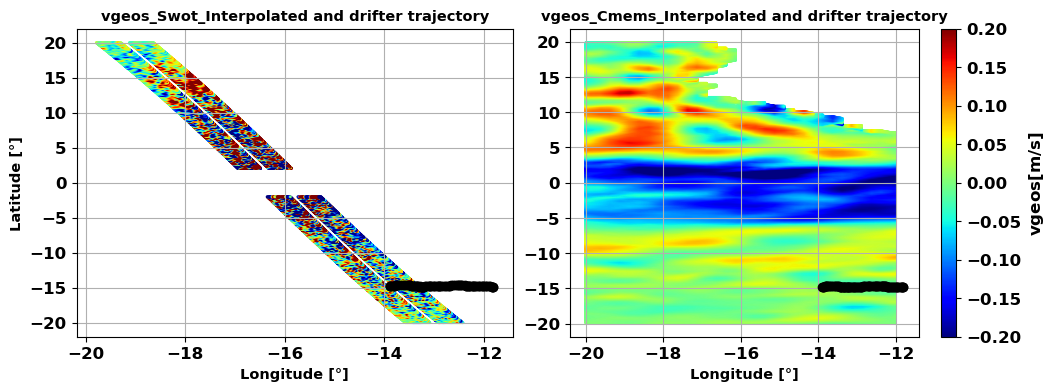

In [64]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique
plt.scatter(grid_x,grid_y,c=vgosa_swot_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.plot(df['longitude'], df['latitude'], color = 'k',  marker='o')

# plt.colorbar(label=r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Swot_Interpolated and drifter trajectory', fontsize=10.5, fontweight='bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique
plt.scatter(grid_x, grid_y, c=vgosa_cmems_interp, s=1, vmin=-0.2, vmax=0.2, cmap='jet')
plt.plot(df['longitude'], df['latitude'], color = 'k',  marker='o')

plt.colorbar(label= r'$\mathbf{vgeos [m/s]}$')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
# plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.title('vgeos_Cmems_Interpolated and drifter trajectory', fontsize=10.5, fontweight='bold')
plt.subplots_adjust(wspace=0.13)  # Ajuster hspace et wspace si nécessaire
plt.savefig("fig12_mode_projection.png", bbox_inches='tight')  
plt.show()